# Fitting ISR Data Example

The purpose of this notebook is to:
* demonstrate the key steps required to fit ISR data
* provide a way to explore how changing different parameters changes chi-squared space
* provide guided exercises in fitting

In this notebook, 2 key steps to fitting the ISR are demonstrated:
* obtain a noisey measurement of the lag products (numerically simulated)
* fit ISR theory using error weight non-linear least squares (Levenburg-Marquardt algorithm)

We are neglecting measurement smearing affects (ambiguity) that occurs in real measurements of lag products. You can modify the initial guess, the true values of the ionosperic parameters (Ne, Te, Ti, vlos), and the uncertainties in the lag products to see how this affects the fitted parameters that are obtained.

In [1]:
%matplotlib inline
import numpy as np
import matplotlib
from matplotlib import pyplot
font = {'size'   : 18}
matplotlib.rc('font', **font)
# set the random seed; get the same results each time we run this notebook
seed = sum([ord(x) for x in 'isrschool'])
np.random.seed(seed)

import ismodel
import scipy.interpolate
import scipy.optimize

# Some Exercises

Below are some exercises to guide you through exploring the fitting process. In each exercise, you will modify a value and see how that affects the resulting fitted parameters.

Between each exercise, use the "Kernel" menu and select "Restart and Run All".


### Exercise 1:
Start with the following values:

>Ne_true = 1.2e11

>Te_true = 2100.

>Ti_true = 1300.

>vlos_true = 0

>K = 1000.

>SNR = 0.1

>initial_guess = [1e10,1500,1000,10]

How close are the fitted parameters to the True values? Do the errors on the fitted parameters seem reasonable?


### Exercise 2:

Now change the number of pulses (K) to be 

$K = 10000$

How does this change the fitted parameter values? What about the errors? What happens to the chi-squared surface vs. Te and Ti?


### Exercise 3:

Now change the number of pulses (K) back to K = 1000 and change the intial guesses:

initial_guess = [1e12,3000,2000,100]

How does this change the fitted parameter values? What about the errors? What happens to the chi-squared surface vs. Te and Ti?



## Step 1: Generate Synthetic Lag Products

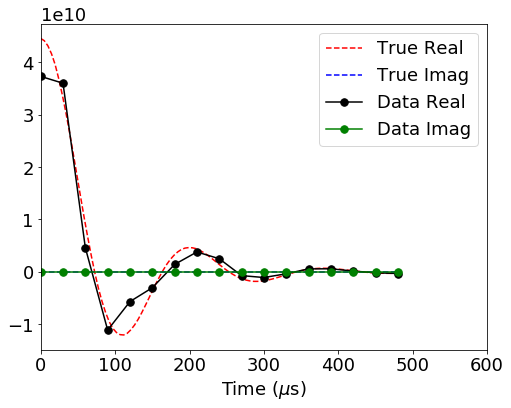

In [2]:
Ne_true = 1.2e11
Te_true = 2100.
Ti_true = 1300.
vlos_true = 0
K = 1000.
SNR = 0.1
initial_guess = [1e10,1500,1000,10]


model_times = np.linspace(0,480,num=100)
data_times = np.linspace(0,480,num=17)

# Run the ISR model to get spectrum and ACF
def is_model(params,ts):
    ne,te,ti,vlos = params
    
    indict={'Nion': 1,'mi': np.array([16]),'B': 5e-5,
            'f0': 449.3e6,'te': te,'alpha': 60.0,'ne': ne, 
            'ti': np.array([ti]),'ni': np.array([1.0]),
            've': vlos,'vi': np.array([vlos]),'nuen': 0.0,
            'nuin': np.array([0.0])}
    cspec = ismodel.ISspec(indict,emode=[1,1,1],imode=[1,1,1],Nfreq=255,czparams=(1e-6,2e5,100,10,1.0))
    ff,spec,tau,acf = cspec.computeSpec()
    mod_ts = tau*1e6
    mod_acf = acf
    
    interps = scipy.interpolate.interp1d(mod_ts,mod_acf,bounds_error=False,fill_value=1e100)
    interp_mod = interps(ts)

    return interp_mod

model_acf = is_model((Ne_true,Te_true,Ti_true,vlos_true),model_times)
data_acf = is_model((Ne_true,Te_true,Ti_true,vlos_true),data_times)


# Now generate some errors
sigma = (1+1/SNR)/np.sqrt(K)
real_errs = sigma*np.random.randn(data_times.size)
imag_errs = sigma*np.random.randn(data_times.size)
data_acf.real *= (1 + real_errs)
data_acf.imag *= (1 + imag_errs)


fig = pyplot.figure(figsize=(8,6))
ax = fig.add_subplot(111)
l = ax.plot(model_times, model_acf.real, 'r--',label='True Real')
l = ax.plot(model_times, model_acf.imag, 'b--',label='True Imag')
l = ax.plot(data_times, data_acf.real, 'k.-',ms=15,label='Data Real')
l = ax.plot(data_times, data_acf.imag, 'g.-',ms=15,label='Data Imag')
l = ax.legend()
l = ax.set_xlim([0,600])
l = ax.set_xlabel('Time ($\mu$s)')

## Step 2: Perform Fit of Model to Data Using Levenburg-Marquardt

In [3]:
def fit_fun(params,ts,data,errs):
    interp_mod = is_model(params,ts)
    
    diffs = (data - interp_mod)/errs
    
    residuals = np.concatenate((diffs.real,diffs.imag))
    
    return residuals
errors = np.abs(data_acf[0])*(1+1/SNR)/np.sqrt(K)

p = scipy.optimize.leastsq(fit_fun, initial_guess, args=(data_times,data_acf,errors),full_output=1,factor=100,epsfcn=1.0e-5)
fits=p[0]
covar = p[1]
fitted_Ne = fits[0]
fitted_Te = fits[1]
fitted_Ti = fits[2]
fitted_vlos = fits[3]
errs_Ne = np.sqrt(covar[0,0])
errs_Te = np.sqrt(covar[1,1])
errs_Ti = np.sqrt(covar[2,2])
errs_vlos = np.sqrt(covar[3,3])

print('Fitted Ne: %0.2e +/- %0.2e -- True Ne: %0.2e' % (fitted_Ne,errs_Ne,Ne_true))
print('Fitted Te: %0.2e +/- %0.2e -- True Te: %0.2e' % (fitted_Te,errs_Te,Te_true))
print('Fitted Ti: %0.2e +/- %0.2e -- True Ti: %0.2e' % (fitted_Ti,errs_Ti,Ti_true))
print('Fitted vlos: %0.2e +/- %0.2e -- True vlos: %0.2e' % (fitted_vlos,errs_vlos,vlos_true))

/home/asreimer/projects/isr_summer_school/2020/data_analysis_and_fitting/summary_and_review/ismodel.py:294: RuntimeWarning: invalid value encountered in double_scalars
  nuei = 1e-6*54.5*self.Params['ne']/self.Params['te']**1.5 # Schunk and Nagy 4.144
/home/asreimer/projects/isr_summer_school/2020/data_analysis_and_fitting/summary_and_review/ismodel.py:295: RuntimeWarning: invalid value encountered in double_scalars
  nuee = 1e-6*54.5/scipy.sqrt(2.0)*self.Params['ne']/self.Params['te']**1.5 # Schunk and Nagy 4.145


Fitted Ne: 1.05e+11 +/- 5.97e+10 -- True Ne: 1.20e+11
Fitted Te: 2.16e+03 +/- 1.15e+03 -- True Te: 2.10e+03
Fitted Ti: 1.49e+03 +/- 1.07e+03 -- True Ti: 1.30e+03
Fitted vlos: -2.32e+00 +/- 3.61e+02 -- True vlos: 0.00e+00


## Visualizing the $\chi ^2$ Surface vs. Te and Ti

In [4]:
num_steps = 30
tes = np.linspace(max([100,fitted_Te-3*errs_Te]),fitted_Te+3*errs_Te,num=num_steps)
tis = np.linspace(max([100,fitted_Ti-3*errs_Ti]),fitted_Ti+3*errs_Ti,num=num_steps)

tes = np.linspace(100,5000,num=num_steps)
tis = np.linspace(100,3000,num=num_steps)


chisquared = np.zeros((num_steps,num_steps))
for j,te in enumerate(tes):
    for k,ti in enumerate(tis):
        chisquared[j,k] = np.sum(fit_fun([fitted_Ne,te,ti,fitted_vlos],data_times,data_acf,errors)**2)

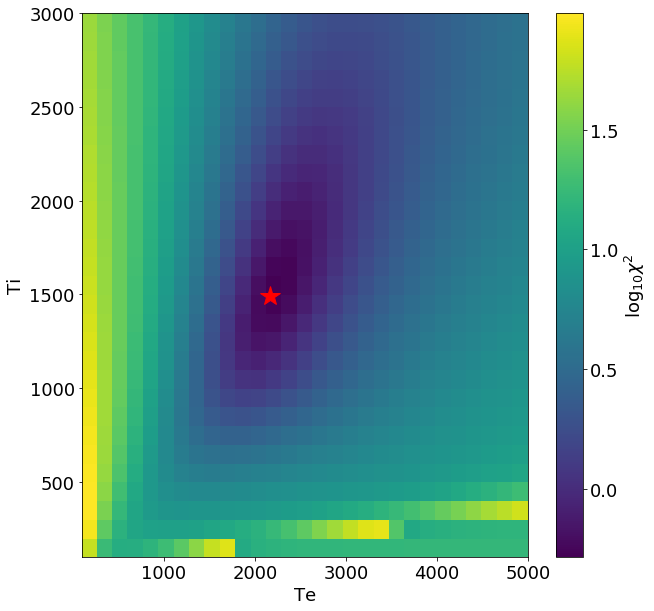

In [5]:
fig = pyplot.figure(figsize=(10,10))
ax1 = fig.add_subplot(111)
X,Y = np.meshgrid(tes,tis)
c = ax1.pcolormesh(X,Y,np.log10(chisquared.T),zorder=1)
l=ax1.plot(fitted_Te,fitted_Ti,'r*',ms=20,zorder=10)
l=ax1.set_xlabel('Te')
l=ax1.set_ylabel('Ti')
cb = pyplot.colorbar(c)
cb.set_label('log$_{10} \chi ^2$')